In [23]:
import requests
from tqdm import tqdm
from os.path import join as oj
import tables, numpy
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import data
from skimage.util import img_as_float
import h5py
from copy import deepcopy
from skimage.filters import gabor_kernel
out_dir = '/scratch/users/vision/data/gallant/vim_2_crcns'

# download data

In [48]:
def download(datafile, username, password, out_dir):
    '''
    Params
    ------
    datafile
    '''
    
    URL = 'https://portal.nersc.gov/project/crcns/download/index.php'
    login_data = dict(
        username=username,
        password=password,
        fn=datafile,
        submit='Login' 
    )

    with requests.Session() as s:
        local_filename = oj(out_dir, login_data['fn'].split('/')[-1])
        print(local_filename)
        r = s.post(URL, data=login_data, stream=True)
        with open(local_filename, 'wb') as f:
            for chunk in tqdm(r.iter_content(chunk_size=1024)):
                if chunk:
                    f.write(chunk)
                    
uname = 'csinva'
pwd = 'password'
dset = 'vim-2'
fnames = ['Stimuli.tar.gz', 'VoxelResponses_subject1.tar.gz', 'anatomy.zip', 'checksums.md5', 'filelist.txt', 'docs']
for fname in fnames:
    fname = oj(dset, fname)
#     download(fname, uname, pwd, out_dir)

In [49]:
ls /scratch/users/vision/data/gallant/vim_2_crcns

anatomy.zip    docs          Stimuli.mat     VoxelResponses_subject1.mat
checksums.md5  filelist.txt  Stimuli.tar.gz  VoxelResponses_subject1.tar.gz


In [23]:
!du -sh /scratch/users/vision/data/gallant/vim_2_crcns
# next extract the tars
# next unzip the zips

6.9G	/scratch/users/vision/data/gallant/vim_2_crcns


In [27]:
!ls /scratch/users/vision/data/gallant/vim_2_crcns/*.gz |xargs -n1 tar -xzf # extract the tar files

# view responses

In [8]:
f = tables.open_file(oj(out_dir, 'VoxelResponses_subject1.mat'))
# f.listNodes # Show all variables available
data = f.get_node('/rt')[:] # training responses: 7200 (timepoints) x 73728
roi = f.get_node('/roi/v1lh')[:].flatten() # structure containing volume matrices (64x64x18) with indices corresponding to each roi in each hemisphere
v1lh_idx = numpy.nonzero(roi==1)[0]
v1lh_resp = data[v1lh_idx]

In [ ]:
f2 = tables.open_file(oj(out_dir, 'Stimuli.mat'))
im = f2.get_node('/st')[100].transpose()
plt.imshow(im)

In [53]:
f2 = tables.open_file(oj(out_dir, 'Stimuli.mat'))

SAMPLING_FREQ = 15
DOWNSAMPLE = 2
OFFSET = SAMPLING_FREQ // 2
ims = np.zeros((7200, 128 // DOWNSAMPLE, 128 // DOWNSAMPLE)).astype(np.int)
for i in tqdm(range(7200)):
    ims[i] = deepcopy(f2.get_node('/st')[OFFSET + i * SAMPLING_FREQ].transpose())[::DOWNSAMPLE, ::DOWNSAMPLE].mean(axis=-1)
    
# save images to file
out_name = oj(out_dir, 'out_st.h5')
if os.path.exists(out_name):
    os.remove(out_name)
f = h5py.File(out_name, 'w')
f['data'] = ims
f.close()    

100%|██████████| 7200/7200 [00:03<00:00, 2354.51it/s]


# view images

(64, 64)
(64, 64)
(64, 64)


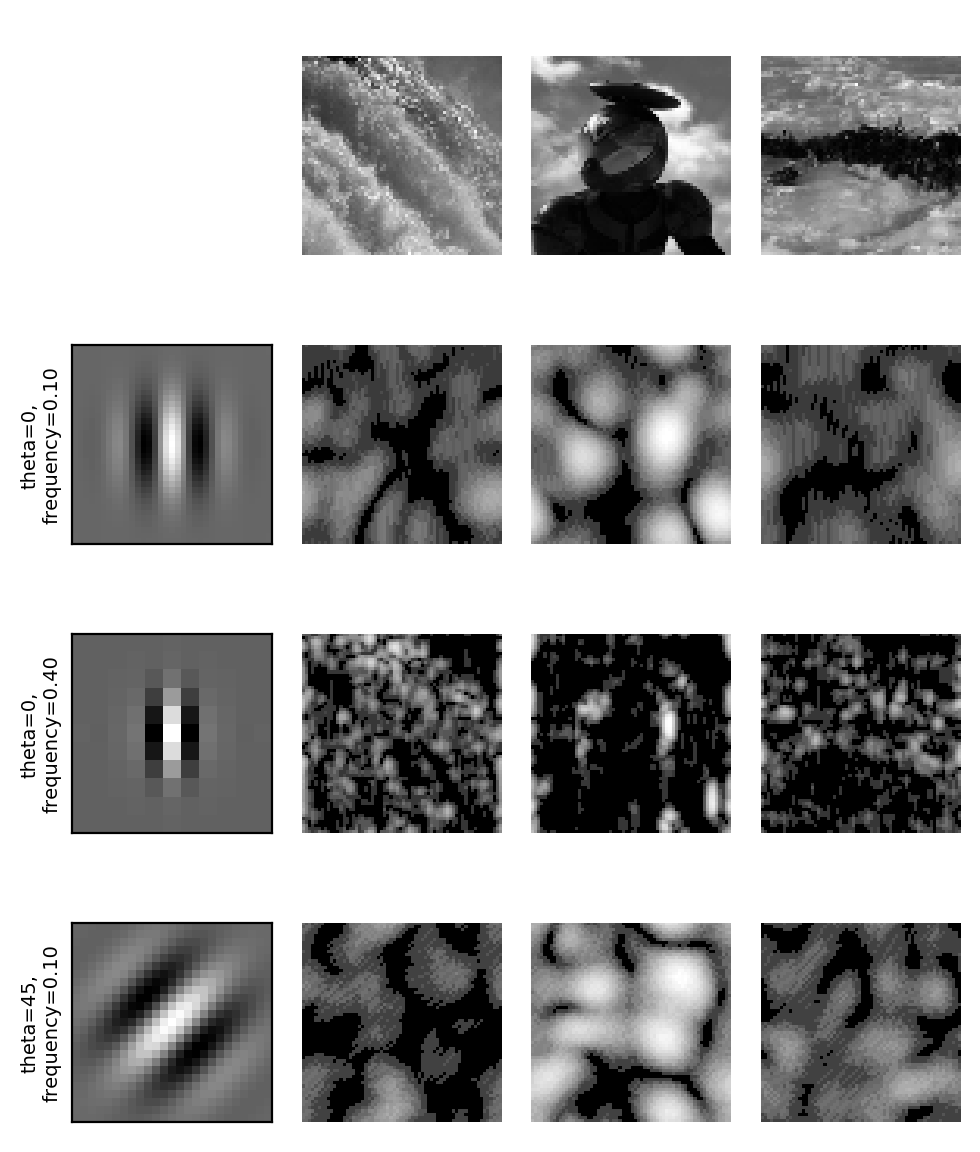

In [55]:
# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma)
            kernels.append(kernel)


brick = h5py.File(out_name, 'r')['data'][0]
grass = h5py.File(out_name, 'r')['data'][100]
gravel = h5py.File(out_name, 'r')['data'][300]
images = [brick, grass, gravel]


def feats(image, kernel):
    
    '''power calculation
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)
    '''
    mag = np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                  ndi.convolve(image, np.imag(kernel), mode='wrap')**2)
    return np.log(1 + mag)



# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in [0, 1]:
    theta = theta / 4. * np.pi
    for frequency in [0.1, 0.4]:
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        results.append((kernel, [feats(img, kernel) for img in images])) # Save kernel and the power image for each image

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(5, 6), dpi=200)
plt.gray()

axes[0][0].axis('off')


# Plot original images
for img, ax in zip(images, axes[0][1:]):
    ax.imshow(img)
    ax.axis('off')

for label, (kernel, feats), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel))
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])
    
for label, (kernel, feats), ax_row in zip(kernel_params, results, axes[1:]):
    ax = ax_row[2]
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    print(feats[0].shape)
    vmin = np.min(feats)
    vmax = np.max(feats)
    for patch, ax in zip(feats, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')  

plt.tight_layout()
plt.show()

# pycortex

In [46]:
import cortex
from cortex import surfs

# ds = cortex.load(oj(out_dir, 'anatomy/S1_anatomy.nii'))

In [ ]:
ds = cortex.load("S1_retinotopy.hdf")

In [40]:
!h5ls S1_retinotopy.hdf

/bin/sh: 1: h5ls: not found


In [ ]:
cortex.webshow(cortex.Volume.random("S1", "fullhead"))

In [ ]:
pts, poly = surfs.getSurf("AH", "fiducial", merge=True)

# nilearn plotting

In [50]:
x = np.random.randn(64, 64, 18)

In [55]:
from nilearn import plotting, datasets

In [ ]:
plotting.plot_glass_brain(x)

In [56]:
motor_images = datasets.fetch_neurovault_motor_task()
stat_img = motor_images.images[0]
# stat_img is just the name of the file that we downloded
stat_img


Dataset created in /accounts/projects/vision/nilearn_data/neurovault



'/accounts/projects/vision/nilearn_data/neurovault/collection_658/image_10426.nii.gz'

In [58]:
stat_img

'/accounts/projects/vision/nilearn_data/neurovault/collection_658/image_10426.nii.gz'